In [ ]:
# ITEGRANTES DEL EQUIPO: 
# Alejandra Monreal León
# Javier Sosa FrancO
# Alma Delia Morales Apolonio

In [1]:
# Importa bibliotecas

import pandas as pd
from pycaret.classification import *
import seaborn as sns
import matplotlib.pyplot as plt
from pycaret.classification import setup
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from scipy.stats import sem  # ✅ Importación que faltaba
import numpy as np

In [ ]:
#  Cargar y explorar la data

df = pd.read_csv('taller2_MLE.csv')

In [3]:
# Muestra estructura del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   edad                   5000 non-null   int64  
 1   segmento               5000 non-null   object 
 2   saldo_total            5000 non-null   float64
 3   numero_productos       5000 non-null   int64  
 4   visitas_app_mes        5000 non-null   int64  
 5   usa_web                5000 non-null   int64  
 6   usa_tarjeta_credito    5000 non-null   int64  
 7   reclamos_6m            5000 non-null   int64  
 8   satisfaccion_encuesta  5000 non-null   float64
 9   tasa_credito_personal  5000 non-null   float64
 10  rango_ingresos         5000 non-null   object 
 11  region                 5000 non-null   object 
 12  cerrara_cuenta         5000 non-null   int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 507.9+ KB


In [4]:
# Presenta información del dataset de los primeros 5 registros
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0


In [5]:
# Agrupar visitas_app_mes en 3 niveles: Bajo, Medio, Alto
df['grupo_visitas_app'] = pd.cut(df['visitas_app_mes'],
                                 bins=[-1, 5, 10, float('inf')],
                                 labels=['Bajo', 'Medio', 'Alto'])

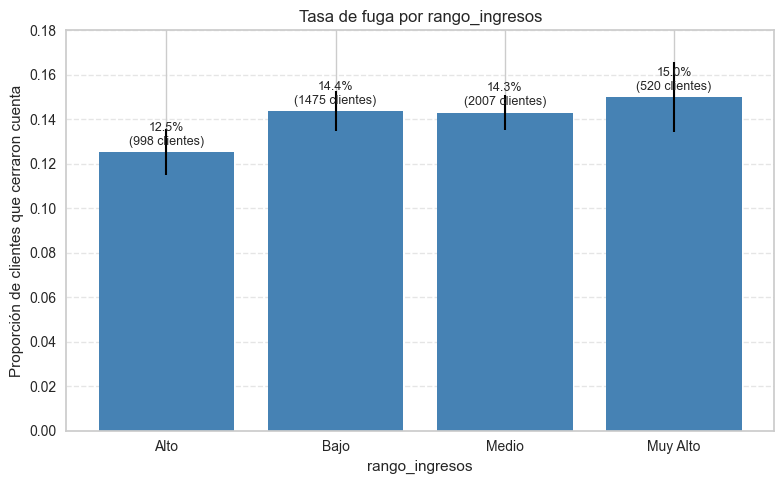

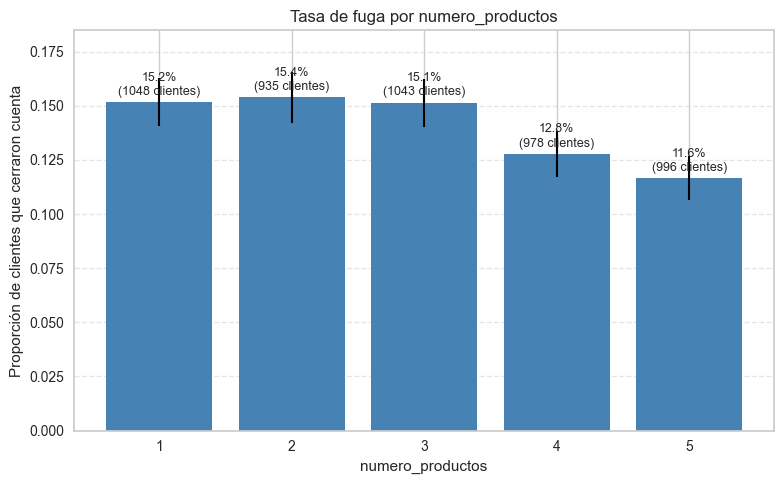

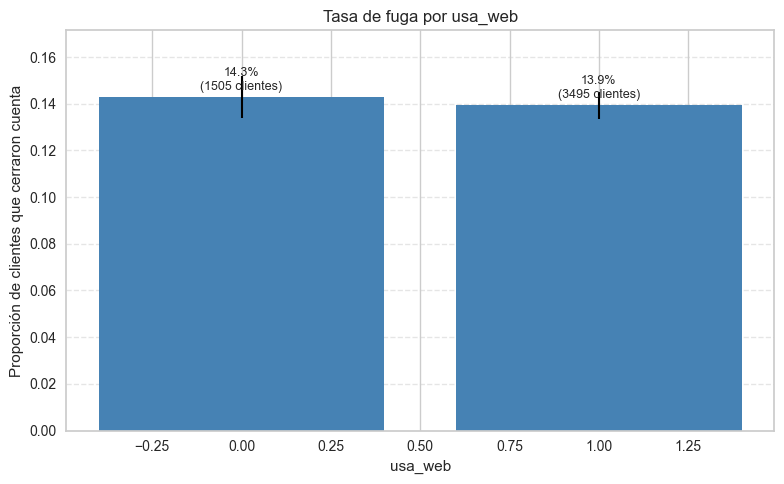

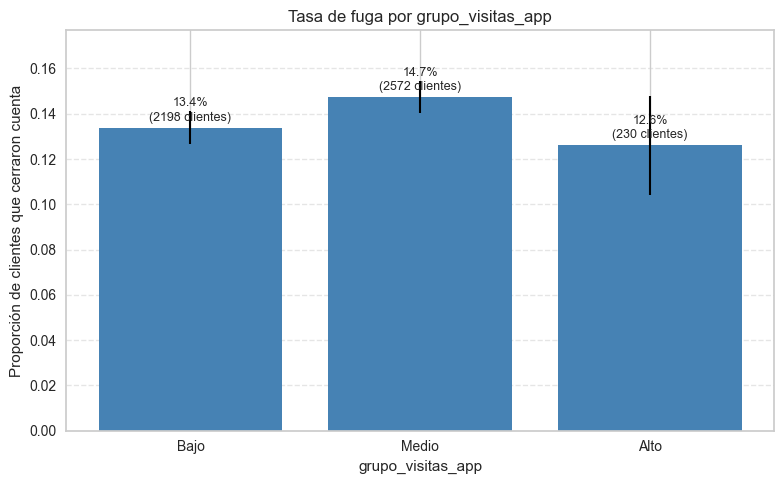

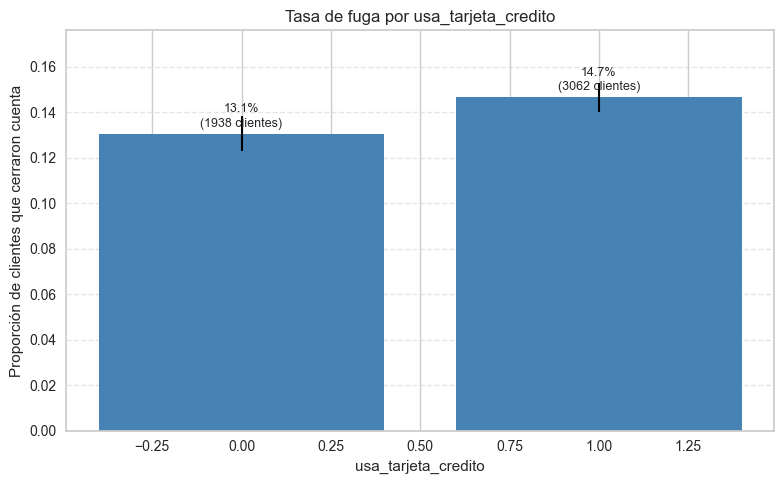

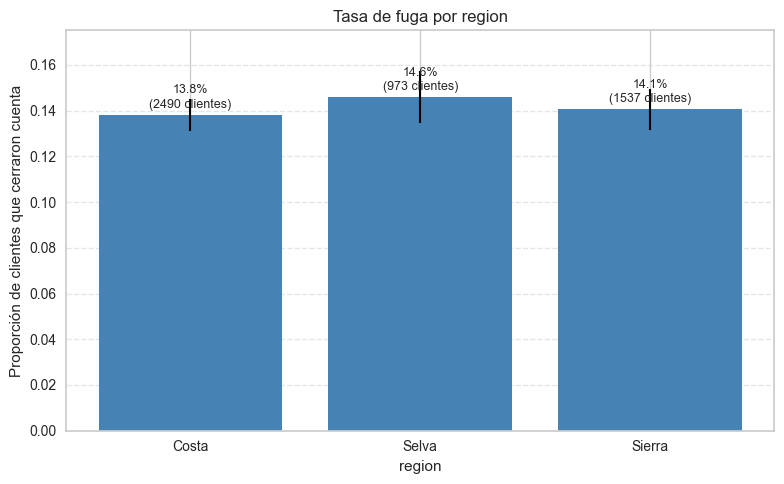

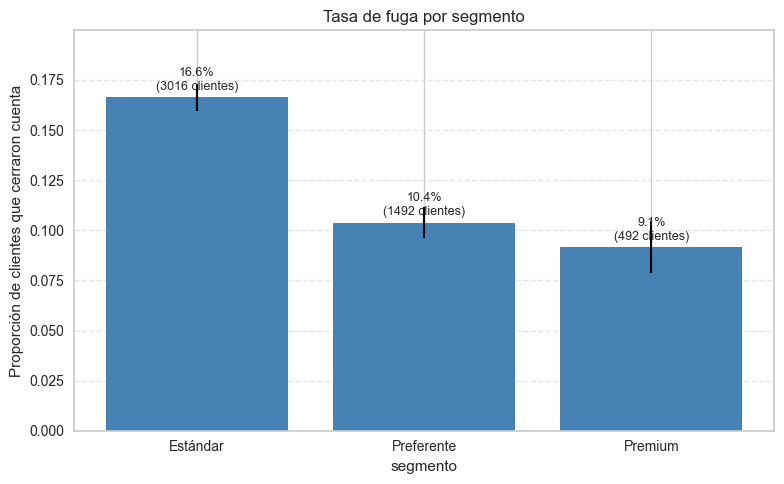

In [6]:
# Muestra las gráficas de barras de variables con porcentaje de fuga

columnas = ['rango_ingresos', 'numero_productos', 'usa_web', 'grupo_visitas_app', 'usa_tarjeta_credito', 'region', 'segmento']

for columna in columnas:

    # Agrupar por grupo de visitas
    agrupado = df.groupby(columna)['cerrara_cuenta']
    proporcion_fuga = agrupado.mean()
    cantidad_clientes = agrupado.count()
    error_estandar = agrupado.apply(sem)  # Error estándar por grupo
    error_max = error_estandar.max()

    # Crear DataFrame para graficar
    tabla = pd.DataFrame({
        columna: proporcion_fuga.index,
        'proporcion_fuga': proporcion_fuga.values,
        'cantidad_clientes': cantidad_clientes.values,
        'error': error_estandar.values
    })

    # Graficar con líneas negras (barra de error)
    fig, ax = plt.subplots(figsize=(8, 5))
    barras = ax.bar(tabla[columna],
                    tabla['proporcion_fuga'],
                    yerr=tabla['error'],
                    capsize=5,             # Tamaño de las líneas negras
                    color='steelblue',
                    ecolor='black',        # Color de la línea de error
                    error_kw={'elinewidth': 1.5})
    barra_max = tabla['proporcion_fuga'].max()

    # Etiquetas
    ax.set_title(f'Tasa de fuga por {columna}')
    ax.set_ylabel('Proporción de clientes que cerraron cuenta')
    ax.set_xlabel(columna)

    # Mostrar porcentajes y cantidad de clientes encima de cada barra
    for bar, porcentaje, cantidad in zip(barras, tabla['proporcion_fuga'], tabla['cantidad_clientes']):
        height = bar.get_height()
        ax.annotate(f'{porcentaje:.1%}\n({cantidad} clientes)',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords="offset points",
                    ha='center', va='bottom', fontsize=9)

    plt.ylim(0, tabla['proporcion_fuga'].max() * 1.2)
    #plt.ylim(0, barra_max + 0.5 + error_max)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

1️⃣ Porcentaje de clientes que cerraron su cuenta: 14.04%
¿Está balanceado?: NO


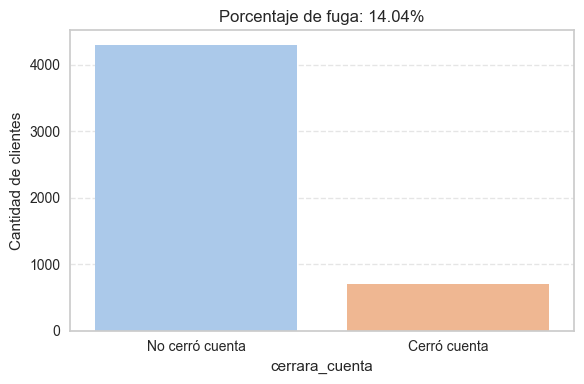

In [7]:
# Porcentaje de fuga y balanceo
porcentaje_fuga = df['cerrara_cuenta'].mean() * 100
print(f"1️⃣ Porcentaje de clientes que cerraron su cuenta: {porcentaje_fuga:.2f}%")
print("¿Está balanceado?:", "NO" if porcentaje_fuga < 40 else "SÍ")


# Contar cantidad de cada clase
fuga_counts = df['cerrara_cuenta'].value_counts().sort_index()
# Crear gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=fuga_counts.index, y=fuga_counts.values, palette="pastel")
# Etiquetas
plt.xticks([0, 1], ['No cerró cuenta', 'Cerró cuenta'])
plt.ylabel('Cantidad de clientes')
plt.title(f'Porcentaje de fuga: {porcentaje_fuga:.2f}%')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

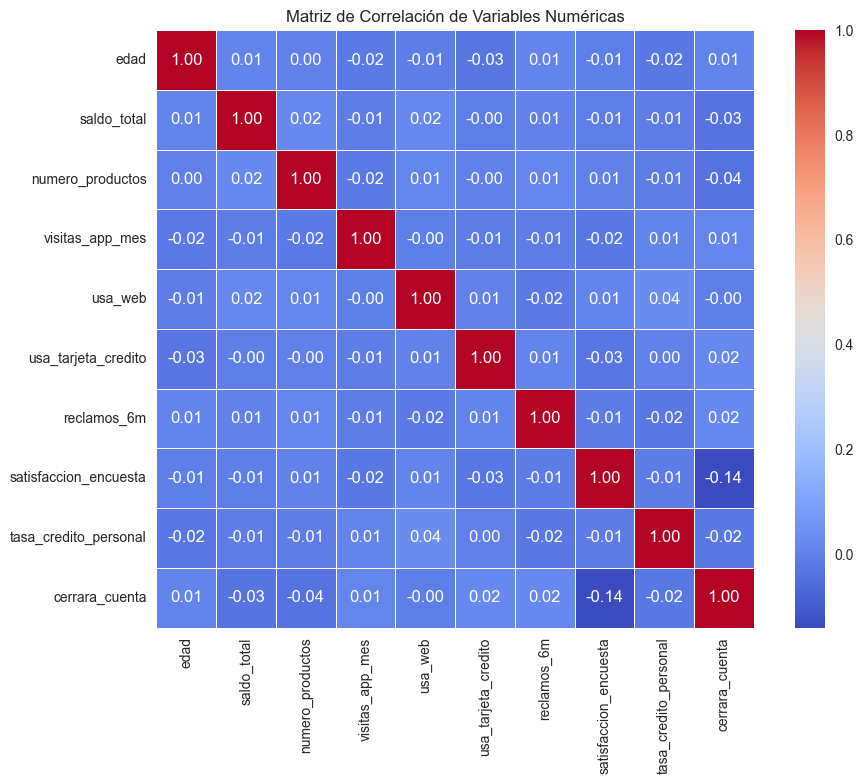

In [ ]:
# Se presenta gráfica de mapa de calor para ver la correlación de las variables
df_numericas = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriz de correlación
correlacion = df_numericas.corr()

# Graficar con mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()

In [ ]:
# Crear cuartiles de saldo_total
df['cuartil_saldo'] = pd.qcut(df['saldo_total'], q=4, labels=['Q1 (bajo)', 'Q2', 'Q3', 'Q4 (alto)'])

conteo = df.groupby(['segmento', 'cuartil_saldo','usa_web']).size().reset_index(name='cantidad_clientes')

conteo = conteo.sort_values(by=['segmento', 'cuartil_saldo','usa_web'])
print(conteo)


      segmento cuartil_saldo  usa_web  cantidad_clientes
0     Estándar     Q1 (bajo)        0                228
1     Estándar     Q1 (bajo)        1                520
2     Estándar            Q2        0                255
3     Estándar            Q2        1                514
4     Estándar            Q3        0                208
5     Estándar            Q3        1                530
6     Estándar     Q4 (alto)        0                223
7     Estándar     Q4 (alto)        1                538
8   Preferente     Q1 (bajo)        0                105
9   Preferente     Q1 (bajo)        1                264
10  Preferente            Q2        0                128
11  Preferente            Q2        1                242
12  Preferente            Q3        0                114
13  Preferente            Q3        1                266
14  Preferente     Q4 (alto)        0                106
15  Preferente     Q4 (alto)        1                267
16     Premium     Q1 (bajo)   

In [ ]:
# Agrupar por las tres dimensiones y calcular cantidad y proporción de fuga
agrupado = df.groupby(['segmento', 'cuartil_saldo', 'usa_web']).agg(
    cantidad_clientes=('cerrara_cuenta', 'count'),
    porcentaje_fuga=('cerrara_cuenta', 'mean')
).reset_index()

# Pivotear para ver columnas 'usa_web' separadas
pivot = agrupado.pivot_table(
    index=['segmento', 'cuartil_saldo'],
    columns='usa_web',
    values=['cantidad_clientes', 'porcentaje_fuga'],
    aggfunc='first'
)

pivot.columns = ['clientes_no_web', 'clientes_web', 'fuga_no_web', 'fuga_web']
pivot = pivot.reset_index()
pivot.head(20).sort_values('fuga_web', ascending=False)

,segmento,cuartil_saldo,clientes_no_web,clientes_web,fuga_no_web,fuga_web
0,Estándar,Q1 (bajo),228,520,0.201754,0.201923
10,Premium,Q3,39,93,0.076923,0.172043
1,Estándar,Q2,255,514,0.172549,0.153696
3,Estándar,Q4 (alto),223,538,0.174888,0.150558
2,Estándar,Q3,208,530,0.158654,0.141509
4,Preferente,Q1 (bajo),105,264,0.133333,0.132576
7,Preferente,Q4 (alto),106,267,0.066038,0.116105
5,Preferente,Q2,128,242,0.078125,0.095041
11,Premium,Q4 (alto),29,87,0.068966,0.091954
8,Premium,Q1 (bajo),39,94,0.025641,0.085106


In [ ]:
# Agrupar por las tres dimensiones y calcular cantidad y proporción de fuga
agrupado = df.groupby(['segmento', 'usa_web']).agg(
    cantidad_clientes=('cerrara_cuenta', 'count'),
    porcentaje_fuga=('cerrara_cuenta', 'mean')
).reset_index()

# Pivotear para ver columnas 'usa_web' separadas
pivot = agrupado.pivot_table(
    index=['segmento'],
    columns='usa_web',
    values=['cantidad_clientes', 'porcentaje_fuga'],
    aggfunc='first'
)

pivot.columns = ['clientes_no_web', 'clientes_web', 'fuga_no_web', 'fuga_web']
pivot = pivot.reset_index()
tabla_pivot = pivot.head(20).sort_values('fuga_web', ascending=False)
tabla_pivot

,segmento,clientes_no_web,clientes_web,fuga_no_web,fuga_web
0,Estándar,914,2102,0.177243,0.161751
1,Preferente,453,1039,0.097130,0.106833
2,Premium,138,354,0.065217,0.101695


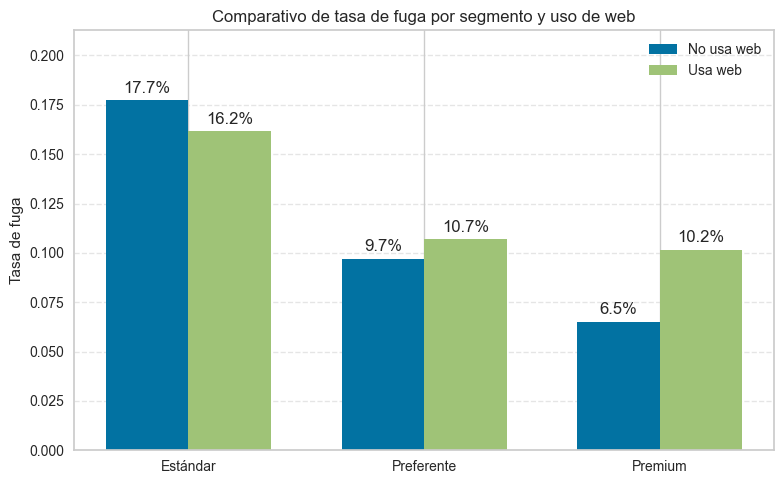

In [ ]:
# Comparativo entre variables de segmento y usa_web  de los que fugan

df_pivot = tabla_pivot

# Configurar la posición de las barras
x = np.arange(len(df_pivot['segmento']))  # ubicaciones en eje X
width = 0.35  # ancho de barra

# Crear gráfico
fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, df_pivot['fuga_no_web'], width, label='No usa web')
bars2 = ax.bar(x + width/2, df_pivot['fuga_web'], width, label='Usa web')

ax.set_ylabel('Tasa de fuga')
ax.set_title('Comparativo de tasa de fuga por segmento y uso de web')
ax.set_xticks(x)
ax.set_xticklabels(df_pivot['segmento'])
ax.legend()

# Agregar porcentajes encima de las barras
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.1%}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.ylim(0, max(df_pivot['fuga_no_web'].max(), df_pivot['fuga_web'].max()) * 1.2)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

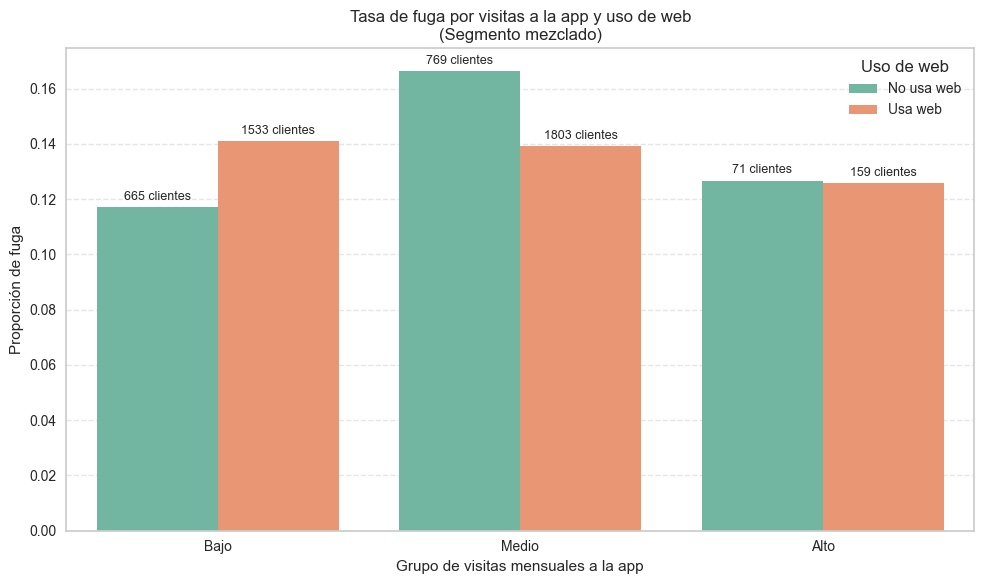

In [ ]:
# Comparativo entre variable segmento, visitas_app_mes agrupadas y usa_web de los que fugan
# Calcular tasa de fuga y cantidad
tabla_visitas = df.groupby(['grupo_visitas_app', 'usa_web']) \
    .agg(tasa_fuga=('cerrara_cuenta', 'mean'),
         cantidad=('cerrara_cuenta', 'count')) \
    .reset_index()

tabla_visitas['usa_web'] = tabla_visitas['usa_web'].map({0: 'No usa web', 1: 'Usa web'})

plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tabla_visitas,
                 x='grupo_visitas_app', y='tasa_fuga',
                 hue='usa_web', palette='Set2', ci=None)

# Agregar número de clientes en cada barra
for i in range(len(tabla_visitas)):
    grupo = tabla_visitas.iloc[i]
    bar = ax.containers[0 if grupo['usa_web'] == 'No usa web' else 1][i // 2]
    height = bar.get_height()
    ax.annotate(f"{grupo['cantidad']} clientes",
                (bar.get_x() + bar.get_width() / 2, height),
                ha='center', va='bottom', fontsize=9, xytext=(0, 3),
                textcoords='offset points')

# Estética
plt.title('Tasa de fuga por visitas a la app y uso de web\n(Segmento mezclado)')
plt.ylabel('Proporción de fuga')
plt.xlabel('Grupo de visitas mensuales a la app')
plt.legend(title='Uso de web')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


In [17]:
# Agrupar satisfacción en niveles (puedes ajustar los cortes)
df['nivel_satisfaccion'] = pd.cut(df['satisfaccion_encuesta'],
                                  bins=[-1, 2.5, 3.5, 4.5, 5],
                                  labels=['Muy baja', 'Baja', 'Media', 'Alta'])

# Calcular la tasa de fuga cruzando las 3 variables
tabla_satisfaccion = df.groupby(['segmento', 'usa_web', 'nivel_satisfaccion'])['cerrara_cuenta'].mean().reset_index()
df.head()


,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta,grupo_visitas_app,cuartil_saldo,nivel_satisfaccion
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0,Alto,Q4 (alto),Media
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0,Medio,Q2,Muy baja
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1,Bajo,Q1 (bajo),Muy baja
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0,Bajo,Q1 (bajo),Alta
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0,Bajo,Q3,Baja


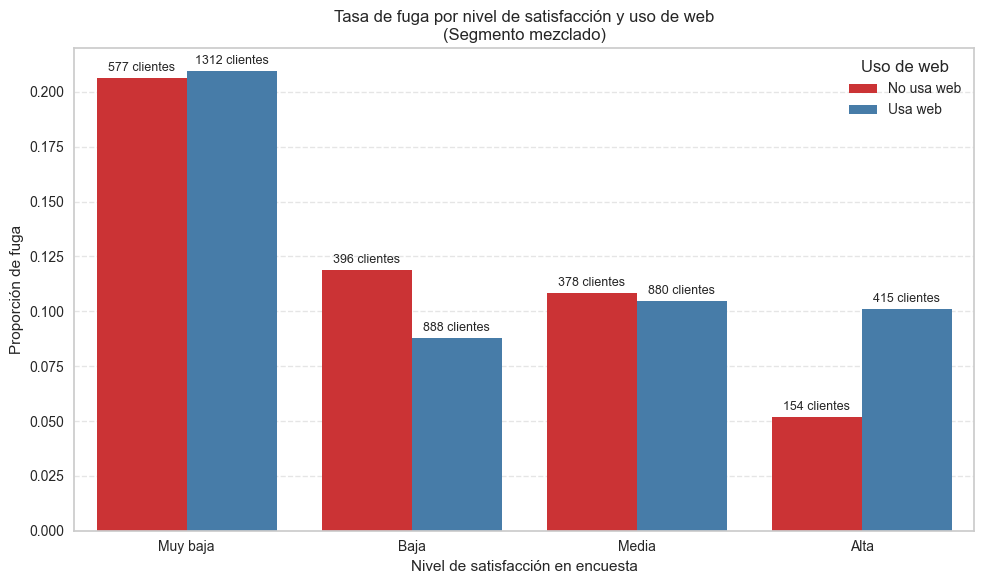

In [ ]:
# Comparativo entre variable segmento, nivel_satisfaccion agrupadas y usa_web de los que fugan
# Agrupación de datos
tabla_satisf = df.groupby(['nivel_satisfaccion', 'usa_web']) \
    .agg(tasa_fuga=('cerrara_cuenta', 'mean'),
         cantidad_clientes=('cerrara_cuenta', 'count')) \
    .reset_index()

tabla_satisf['usa_web'] = tabla_satisf['usa_web'].map({0: 'No usa web', 1: 'Usa web'})

# Gráfica
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=tabla_satisf,
                 x='nivel_satisfaccion', y='tasa_fuga',
                 hue='usa_web', ci=None, palette='Set1')

# Agregar número de clientes usando zip para asociar bien cada barra con su dato
for container, hue_label in zip(ax.containers, ['No usa web', 'Usa web']):
    datos_grupo = tabla_satisf[tabla_satisf['usa_web'] == hue_label]
    for bar, (_, fila) in zip(container, datos_grupo.iterrows()):
        height = bar.get_height()
        cantidad = fila['cantidad_clientes']
        ax.annotate(f"{int(cantidad)} clientes",
                    (bar.get_x() + bar.get_width() / 2, height),
                    ha='center', va='bottom', fontsize=9, xytext=(0, 3),
                    textcoords='offset points')

# Estética
plt.title('Tasa de fuga por nivel de satisfacción y uso de web\n(Segmento mezclado)')
plt.ylabel('Proporción de fuga')
plt.xlabel('Nivel de satisfacción en encuesta')
plt.legend(title='Uso de web')
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

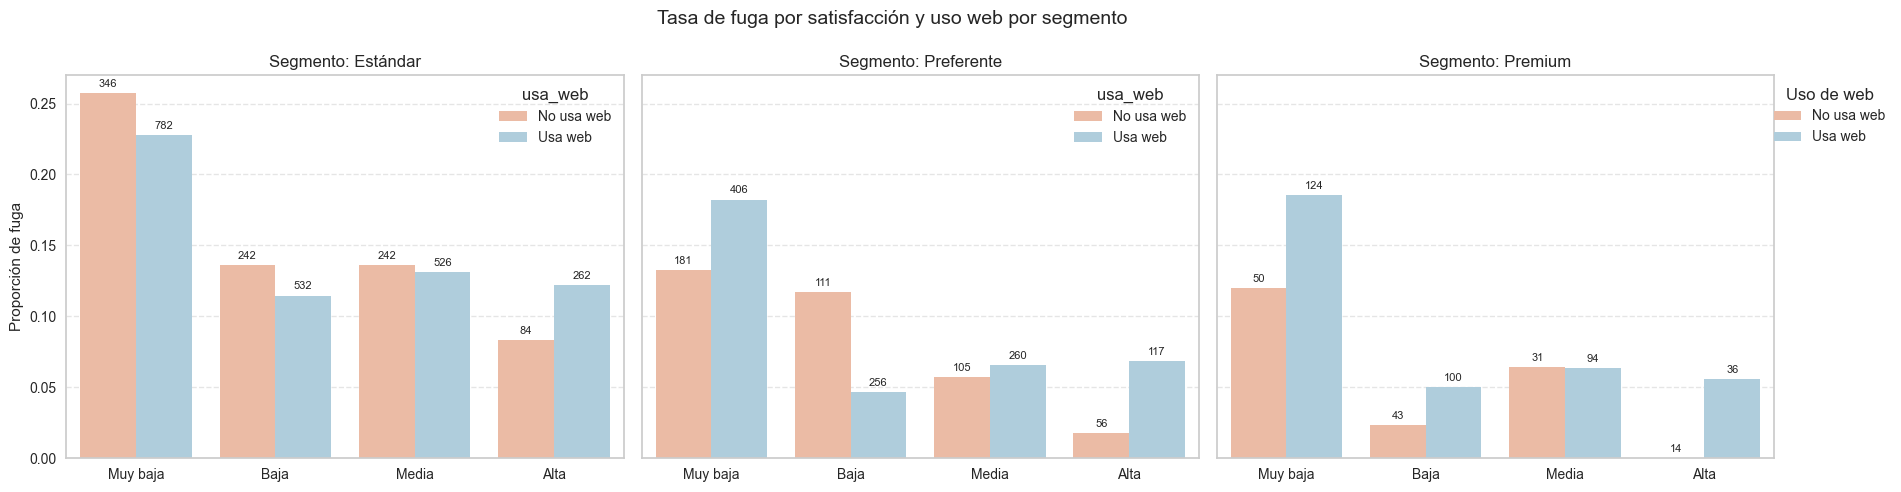

In [ ]:
# Comparativo entre variable segmento, nivel_satisfaccion agrupadas y usa_web de los que fugan por segmento

# Calcular tasa de fuga y cantidad de clientes por grupo
tabla = df.groupby(['segmento', 'nivel_satisfaccion', 'usa_web']) \
    .agg(tasa_fuga=('cerrara_cuenta', 'mean'),
         cantidad=('cerrara_cuenta', 'count')).reset_index()

tabla['usa_web'] = tabla['usa_web'].map({0: 'No usa web', 1: 'Usa web'})

segmentos = tabla['segmento'].unique()
fig, axes = plt.subplots(1, len(segmentos), figsize=(18, 5), sharey=True)

for ax, seg in zip(axes, segmentos):
    data_seg = tabla[tabla['segmento'] == seg]
    sns.barplot(data=data_seg,
                x='nivel_satisfaccion', y='tasa_fuga',
                hue='usa_web', ci=None, ax=ax, palette='RdBu')

    # Agregar cantidad encima de las barras
    for container, hue_label in zip(ax.containers, ['No usa web', 'Usa web']):
        datos = data_seg[data_seg['usa_web'] == hue_label]
        for bar, (_, row) in zip(container, datos.iterrows()):
            height = bar.get_height()
            cantidad = row['cantidad']
            ax.annotate(f"{int(cantidad)}",
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords='offset points',
                        ha='center', va='bottom', fontsize=8)

    ax.set_title(f"Segmento: {seg}")
    ax.set_xlabel("")
    ax.set_ylabel("Proporción de fuga")
    ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.suptitle('Tasa de fuga por satisfacción y uso web por segmento', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.legend(title='Uso de web', loc='upper center', bbox_to_anchor=(1.1, 1))
plt.show()

In [120]:
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta,cuartil_saldo,valor_cliente
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0,Q4 (alto),Alto
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0,Q2,Bajo
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1,Q1 (bajo),Medio
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0,Q1 (bajo),Medio
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0,Q3,Medio


In [ ]:
# Clasificación del segmento y cuatiles y ponerlo en valor_cliente

#  Clasificar valor del cliente
def clasifica_valor_cliente(row):
    if row['segmento'] == 'Premium':
        return 'Alto'
    elif row['segmento'] == 'Preferente' and row['cuartil_saldo'] == 'Q4 (alto)':
        return 'Alto'
    elif row['cuartil_saldo'] in ['Q3', 'Q4 (alto)'] or row['numero_productos'] > 2:
        return 'Medio'
    else:
        return 'Bajo'

df['valor_cliente'] = df.apply(clasifica_valor_cliente, axis=1)

In [ ]:
# Calcula porcentaje de clientes silenciosos 

# Filtrar clientes sin reclamos
df_silenciosos = df[df['reclamos_6m'] == 0]

# Calcular porcentaje de fuga entre ellos
porcentaje_silenciosos_fugan = df_silenciosos['cerrara_cuenta'].mean() * 100
print(f"Porcentaje de fuga entre clientes silenciosos: {porcentaje_silenciosos_fugan:.2f}%")

Porcentaje de fuga entre clientes silenciosos: 13.63%


In [22]:
# Agrupar por cerrara_cuenta dentro del grupo silencioso
perfil_silenciosos = df_silenciosos.groupby('cerrara_cuenta')[[
    'saldo_total', 'visitas_app_mes', 'satisfaccion_encuesta'
]].mean().rename(index={0: 'No fugó', 1: 'Sí fugó'})

print(perfil_silenciosos)

                 saldo_total  visitas_app_mes  satisfaccion_encuesta
cerrara_cuenta                                                      
No fugó         20513.020946         6.062074               3.087661
Sí fugó         19682.240240         6.074341               2.646523


In [23]:
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta,grupo_visitas_app,cuartil_saldo,nivel_satisfaccion,valor_cliente
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0,Alto,Q4 (alto),Media,Alto
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0,Medio,Q2,Muy baja,Bajo
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1,Bajo,Q1 (bajo),Muy baja,Medio
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0,Bajo,Q1 (bajo),Alta,Medio
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0,Bajo,Q3,Baja,Medio


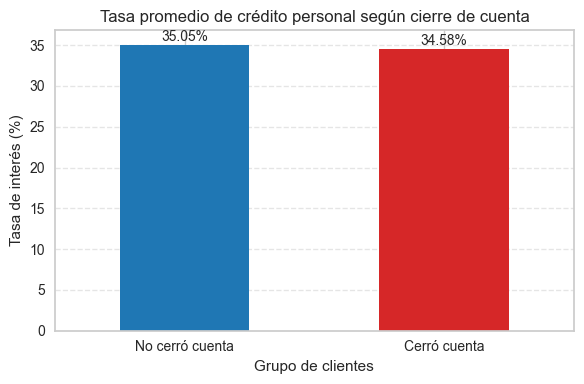

In [ ]:
# Comportamiento de variable tasa_credito_personal con fuga

# Calcular la tasa promedio por grupo
tasa_promedio = df.groupby('cerrara_cuenta')['tasa_credito_personal'].mean().rename(index={0: 'No cerró cuenta', 1: 'Cerró cuenta'})

tasa_promedio.plot(kind='bar', color=['#1f77b4', '#d62728'], figsize=(6, 4))
plt.title('Tasa promedio de crédito personal según cierre de cuenta')
plt.ylabel('Tasa de interés (%)')
plt.xlabel('Grupo de clientes')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Agregar etiquetas de valor encima de las barras
for index, value in enumerate(tasa_promedio):
    plt.text(index, value + 0.1, f'{value:.2f}%', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

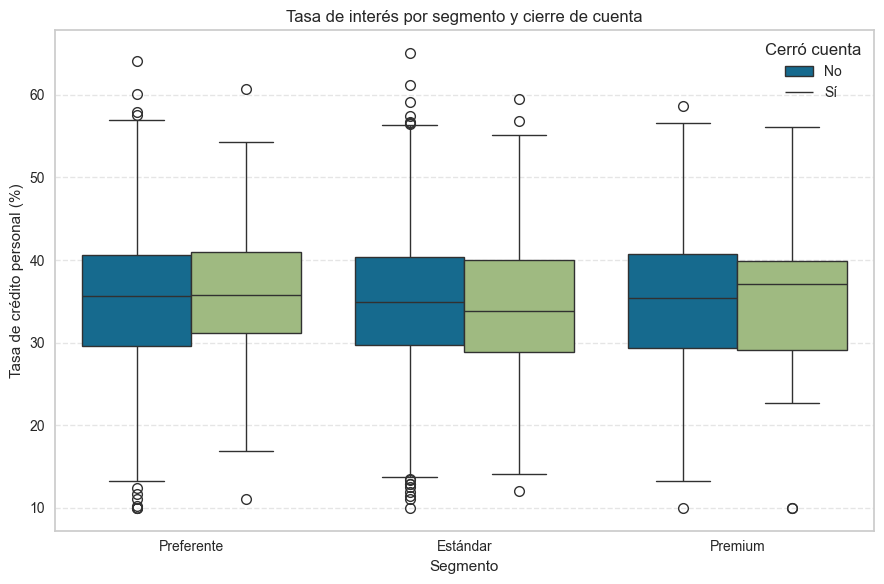

In [25]:
# Crear gráfica de caja para comparar tasa según fuga, dentro de cada segmento
plt.figure(figsize=(9, 6))
sns.boxplot(data=df, x='segmento', y='tasa_credito_personal', hue='cerrara_cuenta')
plt.title('Tasa de interés por segmento y cierre de cuenta')
plt.ylabel('Tasa de crédito personal (%)')
plt.xlabel('Segmento')
plt.legend(title='Cerró cuenta', labels=['No', 'Sí'])
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [26]:
# Calcular tasa promedio por segmento y fuga
df.groupby(['segmento', 'cerrara_cuenta'])['tasa_credito_personal'].mean().unstack()

cerrara_cuenta,0,1
segmento,,
Estándar,34.989069,34.196474
Preferente,35.116821,35.616000
Premium,35.210984,35.348000


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   edad                   5000 non-null   int64   
 1   segmento               5000 non-null   object  
 2   saldo_total            5000 non-null   float64 
 3   numero_productos       5000 non-null   int64   
 4   visitas_app_mes        5000 non-null   int64   
 5   usa_web                5000 non-null   int64   
 6   usa_tarjeta_credito    5000 non-null   int64   
 7   reclamos_6m            5000 non-null   int64   
 8   satisfaccion_encuesta  5000 non-null   float64 
 9   tasa_credito_personal  5000 non-null   float64 
 10  rango_ingresos         5000 non-null   object  
 11  region                 5000 non-null   object  
 12  cerrara_cuenta         5000 non-null   int64   
 13  grupo_visitas_app      5000 non-null   category
 14  cuartil_saldo          5000 non-null   c

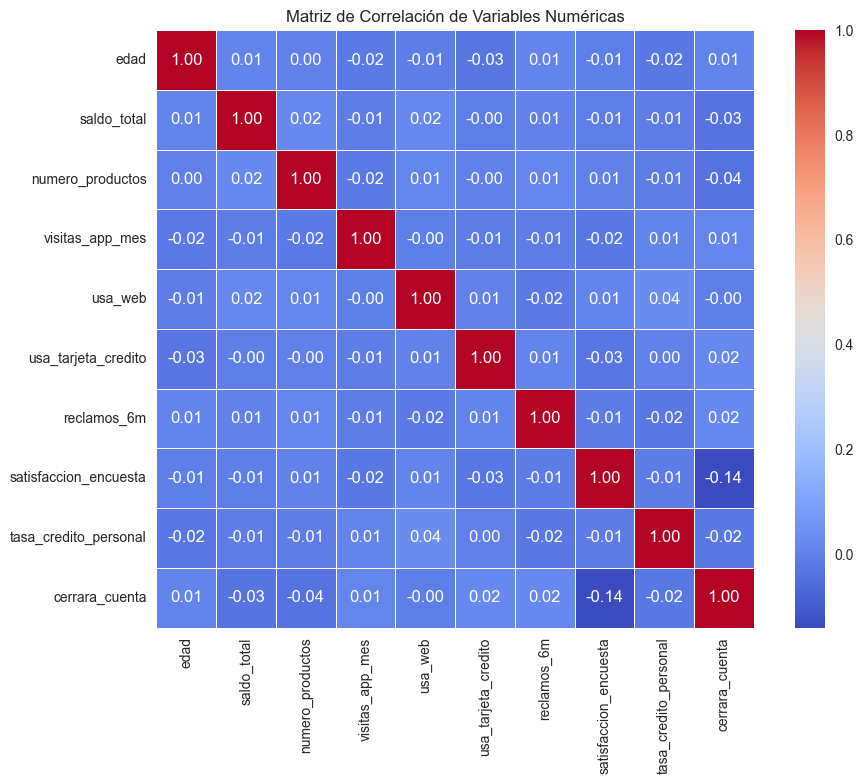

In [ ]:
# Se presenta gráfica de mapa de calor para ver la correlación de las variables

df_numericas = df.select_dtypes(include=['int64', 'float64'])

# Calcular matriz de correlación
correlacion = df_numericas.corr()

# Graficar con mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=0.5)
plt.title('Matriz de Correlación de Variables Numéricas')
plt.tight_layout()
plt.show()

In [29]:
print(df.shape)
display(df.head())
df.dtypes

(5000, 17)


,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta,grupo_visitas_app,cuartil_saldo,nivel_satisfaccion,valor_cliente
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0,Alto,Q4 (alto),Media,Alto
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0,Medio,Q2,Muy baja,Bajo
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1,Bajo,Q1 (bajo),Muy baja,Medio
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0,Bajo,Q1 (bajo),Alta,Medio
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0,Bajo,Q3,Baja,Medio


edad                        int64
segmento                   object
saldo_total               float64
numero_productos            int64
visitas_app_mes             int64
usa_web                     int64
usa_tarjeta_credito         int64
reclamos_6m                 int64
satisfaccion_encuesta     float64
tasa_credito_personal     float64
rango_ingresos             object
region                     object
cerrara_cuenta              int64
grupo_visitas_app        category
cuartil_saldo            category
nivel_satisfaccion       category
valor_cliente              object
dtype: object

In [ ]:
# Conversión de variables tipo objeto a categórica

df['segmento'] = df['segmento'].astype('category')
df['region'] = df['region'].astype('category')
df['rango_ingresos'] = df['rango_ingresos'].astype('category')


In [ ]:
# Configuración de setup

clf1 = setup(
    data=df,
    target='cerrara_cuenta',
    session_id=777,
    categorical_features=['segmento', 'rango_ingresos', 'region','grupo_visitas_app','cuartil_saldo','nivel_satisfaccion','valor_cliente'],
    bin_numeric_features=['usa_web', 'usa_tarjeta_credito'],
    fix_imbalance=True,
    remove_multicollinearity=True,
    multicollinearity_threshold=0.8,
    transformation=True,
    transformation_method='yeo-johnson'
)

,Description,Value
0,Session id,777
1,Target,cerrara_cuenta
2,Target type,Binary
3,Original data shape,"(5000, 17)"
4,Transformed data shape,"(7518, 34)"
5,Transformed train set shape,"(6018, 34)"
6,Transformed test set shape,"(1500, 34)"
7,Numeric features,9
8,Categorical features,7
9,Preprocess,True


In [ ]:
# Compara modelos

best_model = compare_models(sort='Recall')
final_model = finalize_model(best_model)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,09:02:54
Status,. . . . . . . . . . . . . . . . . .,Loading Dependencies
Estimator,. . . . . . . . . . . . . . . . . .,Compiling Library


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
svm,SVM - Linear Kernel,0.5726,0.6105,0.4896,0.2277,0.2177,0.0626,0.0815,0.0630
nb,Naive Bayes,0.6683,0.6222,0.4400,0.1966,0.2715,0.0962,0.1091,0.0530
lr,Logistic Regression,0.7251,0.6192,0.3870,0.2240,0.2832,0.1284,0.1358,0.1390
knn,K Neighbors Classifier,0.5769,0.4955,0.3684,0.1347,0.1966,-0.0108,-0.0145,0.0590
dt,Decision Tree Classifier,0.7403,0.5192,0.2119,0.1659,0.1857,0.0341,0.0346,0.0590
ridge,Ridge Classifier,0.8114,0.6331,0.1445,0.2358,0.1777,0.0779,0.0818,0.0530
xgboost,Extreme Gradient Boosting,0.8423,0.5796,0.0631,0.2602,0.1006,0.0474,0.0629,0.2430
lda,Linear Discriminant Analysis,0.8546,0.6473,0.0346,0.3248,0.0619,0.0365,0.0652,0.0560
lightgbm,Light Gradient Boosting Machine,0.8509,0.5949,0.0244,0.1847,0.0426,0.0157,0.0234,0.2610
et,Extra Trees Classifier,0.8434,0.5832,0.0224,0.1419,0.0381,-0.0001,0.0003,0.1490


In [34]:
# El mejor modelo es svm. Como no soporta algunas funcionalidades vamos a utilizar lr

lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7743,0.7102,0.5306,0.3171,0.3969,0.2688,0.2823
1,0.6971,0.5983,0.3469,0.1868,0.2429,0.0744,0.0800
2,0.7229,0.6157,0.3061,0.1923,0.2362,0.0776,0.0807
3,0.7486,0.6581,0.3878,0.2468,0.3016,0.1574,0.1634
4,0.7200,0.5398,0.3673,0.2118,0.2687,0.1107,0.1171
5,0.7257,0.6687,0.4898,0.2526,0.3333,0.1823,0.1981
6,0.6857,0.5545,0.3061,0.1648,0.2143,0.0395,0.0424
7,0.7286,0.5808,0.3265,0.2051,0.2520,0.0966,0.1005
8,0.7057,0.6266,0.4286,0.2188,0.2897,0.1280,0.1395


In [35]:
print(lr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7829,0.6956,0.4898,0.3200,0.3871,0.2621,0.2709
1,0.7114,0.5862,0.3061,0.1829,0.2290,0.0652,0.0684
2,0.7086,0.6078,0.2653,0.1646,0.2031,0.0366,0.0382
3,0.7543,0.6489,0.3265,0.2319,0.2712,0.1285,0.1312
4,0.7057,0.5424,0.3469,0.1932,0.2482,0.0833,0.0888
5,0.7200,0.6529,0.4694,0.2421,0.3194,0.1652,0.1796
6,0.7000,0.5516,0.3265,0.1818,0.2336,0.0655,0.0698
7,0.7371,0.5594,0.3265,0.2133,0.2581,0.1068,0.1104
8,0.7429,0.6333,0.4286,0.2530,0.3182,0.1725,0.1816


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


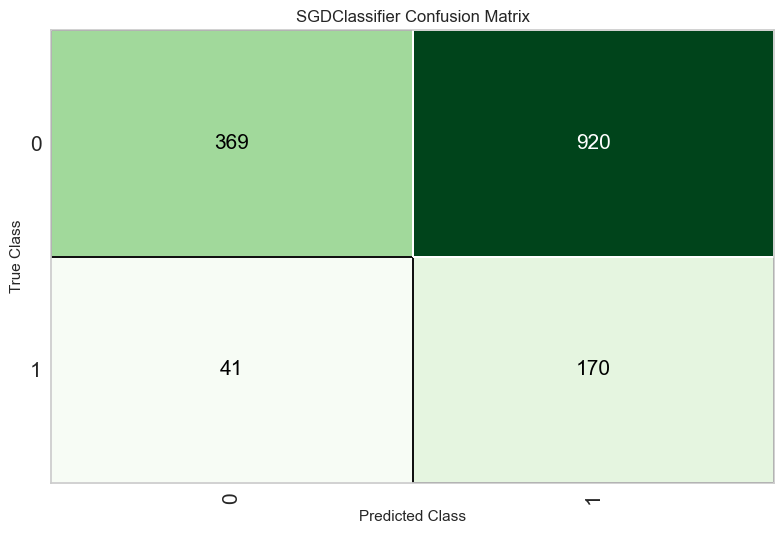

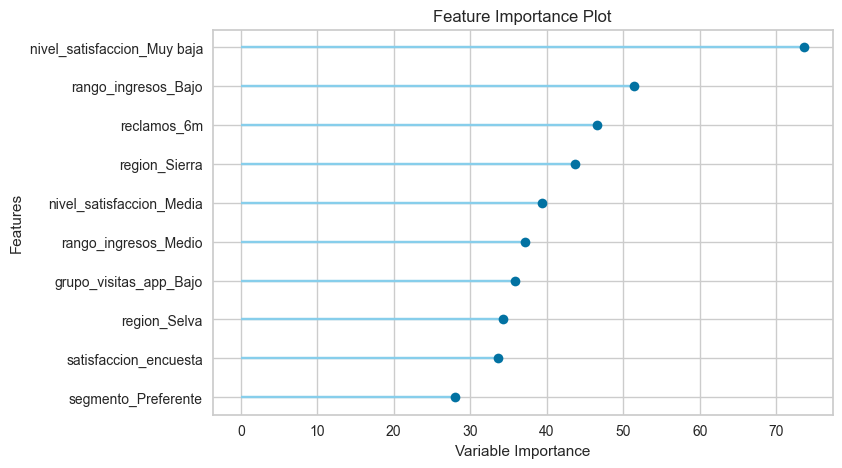

In [36]:
#  Evaluación de sensibilidad para reducir falsos negativos
tune_lr = tune_model(lr, optimize='Recall')
plot_model(final_model, plot='confusion_matrix')
plot_model(final_model, plot='feature')

In [ ]:
# Predección del modelo tuneado

predict_model(tune_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7187,0.5933,0.3128,0.1924,0.2383,0.0776,0.0810


,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,grupo_visitas_app,cuartil_saldo,nivel_satisfaccion,valor_cliente,cerrara_cuenta,prediction_label,prediction_score
3199,29,Estándar,19481.150391,3,7,1,0,1,2.2,34.369999,Alto,Selva,Medio,Q2,Muy baja,Medio,0,0,0.5558
4092,46,Preferente,0.000000,1,6,1,0,1,4.5,42.470001,Bajo,Costa,Medio,Q1 (bajo),Media,Bajo,1,0,0.5500
179,39,Estándar,6418.149902,2,6,1,1,0,4.8,41.959999,Medio,Costa,Medio,Q1 (bajo),Alta,Bajo,0,0,0.8337
206,73,Estándar,48492.050781,5,4,1,1,0,4.4,35.869999,Alto,Costa,Bajo,Q4 (alto),Media,Medio,0,0,0.7232
2601,29,Preferente,15465.570312,1,5,1,0,0,1.6,36.570000,Bajo,Sierra,Bajo,Q2,Muy baja,Bajo,0,0,0.5000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2289,58,Estándar,10790.230469,1,5,0,0,0,1.9,28.920000,Medio,Costa,Bajo,Q2,Muy baja,Bajo,0,1,0.7404
598,46,Estándar,39807.191406,1,6,1,0,0,4.9,35.549999,Muy Alto,Sierra,Medio,Q4 (alto),Alta,Medio,1,0,0.9570
2365,64,Estándar,27787.449219,4,5,1,1,0,4.9,32.340000,Medio,Costa,Bajo,Q3,Alta,Medio,0,0,0.8021
2889,51,Estándar,26796.980469,2,5,0,0,2,2.8,43.779999,Bajo,Selva,Bajo,Q3,Baja,Medio,0,0,0.5354


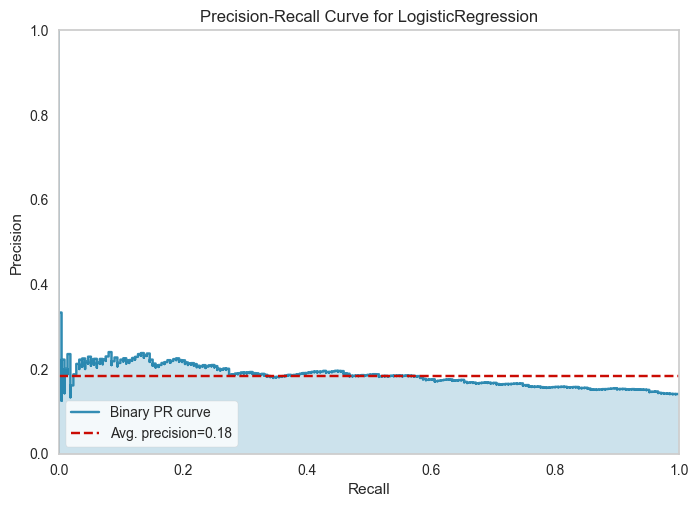

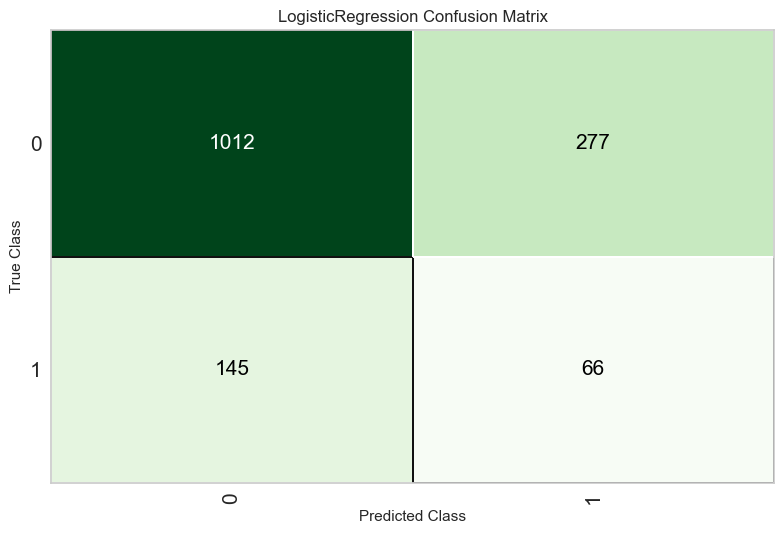

In [ ]:
# Ajuste fino y visualización
#qda = tune_model(qda, optimize='Recall')
plot_model(tune_lr, plot='pr')  # Precision-Recall
plot_model(tune_lr, plot='confusion_matrix')

In [40]:
!pip install shap

In [ ]:
predict_model(tune_lr)

predicciones = predict_model(tune_lr, raw_score=True)
print(predicciones.columns)  

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7187,0.5933,0.3128,0.1924,0.2383,0.0776,0.0810


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7187,0.5933,0.3128,0.1924,0.2383,0.0776,0.0810


Index(['edad', 'segmento', 'saldo_total', 'numero_productos',
       'visitas_app_mes', 'usa_web', 'usa_tarjeta_credito', 'reclamos_6m',
       'satisfaccion_encuesta', 'tasa_credito_personal', 'rango_ingresos',
       'region', 'grupo_visitas_app', 'cuartil_saldo', 'nivel_satisfaccion',
       'valor_cliente', 'cerrara_cuenta', 'prediction_label',
       'prediction_score_0', 'prediction_score_1'],
      dtype='object')


In [147]:
tune_lr

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
evaluate_model(tune_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [51]:
#  Interpretación 
interpret_model(tune_lr, plot='summary')


TypeError: This function only supports tree based models for binary classification: lightgbm, dt, et, rf, catboost, xgboost.

In [48]:
#  Interpretación 
interpret_model(tune_lr, plot='pdp')

In [53]:
predicciones = predict_model(tune_lr, raw_score=True)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7187,0.5933,0.3128,0.1924,0.2383,0.0776,0.0810


In [54]:
print(predicciones.columns)

Index(['edad', 'segmento', 'saldo_total', 'numero_productos',
       'visitas_app_mes', 'usa_web', 'usa_tarjeta_credito', 'reclamos_6m',
       'satisfaccion_encuesta', 'tasa_credito_personal', 'rango_ingresos',
       'region', 'grupo_visitas_app', 'cuartil_saldo', 'nivel_satisfaccion',
       'valor_cliente', 'cerrara_cuenta', 'prediction_label',
       'prediction_score_0', 'prediction_score_1'],
      dtype='object')


In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype   
---  ------                 --------------  -----   
 0   edad                   5000 non-null   int64   
 1   segmento               5000 non-null   category
 2   saldo_total            5000 non-null   float64 
 3   numero_productos       5000 non-null   int64   
 4   visitas_app_mes        5000 non-null   int64   
 5   usa_web                5000 non-null   int64   
 6   usa_tarjeta_credito    5000 non-null   int64   
 7   reclamos_6m            5000 non-null   int64   
 8   satisfaccion_encuesta  5000 non-null   float64 
 9   tasa_credito_personal  5000 non-null   float64 
 10  rango_ingresos         5000 non-null   category
 11  region                 5000 non-null   category
 12  cerrara_cuenta         5000 non-null   int64   
 13  grupo_visitas_app      5000 non-null   category
 14  cuartil_saldo          5000 non-null   c

In [56]:
print(get_config("X"))
print(get_config("trained_model"))

      edad    segmento   saldo_total  numero_productos  visitas_app_mes  \
3117    68    Estándar  31682.500000                 2               12   
3084    70    Estándar   8036.029785                 2                7   
1068    70     Premium  17904.910156                 1                5   
1244    50    Estándar   9202.280273                 3               10   
1184    60  Preferente   3642.370117                 3                6   
...    ...         ...           ...               ...              ...   
2289    58    Estándar  10790.230469                 1                5   
598     46    Estándar  39807.191406                 1                6   
2365    64    Estándar  27787.449219                 4                5   
2889    51    Estándar  26796.980469                 2                5   
4482    71  Preferente  17676.970703                 1                4   

      usa_web  usa_tarjeta_credito  reclamos_6m  satisfaccion_encuesta  \
3117        1            

ValueError: Variable 'trained_model' not found. Possible variables are: ['n_jobs_param', 'target_param', 'X', 'test', 'seed', 'fold_groups_param', 'test_transformed', 'X_train_transformed', 'variable_and_property_keys', 'dataset', 'X_test', 'fix_imbalance', 'pipeline', 'X_test_transformed', 'variables', 'y_train_transformed', 'logging_param', 'exp_name_log', 'y_transformed', 'fold_generator', 'fold_shuffle_param', '_ml_usecase', 'gpu_param', '_available_plots', 'html_param', 'idx', 'train_transformed', 'memory', 'exp_id', 'train', 'y', 'y_test', 'y_test_transformed', 'is_multiclass', 'data', 'X_transformed', 'USI', 'gpu_n_jobs_param', 'y_train', 'X_train', 'dataset_transformed', 'log_plots_param']

In [57]:
from pycaret.classification import get_config

# Obtener X ya alineado con el modelo
X = get_config("X")

# Asegurarte de que usas el modelo correcto
lr = get_config(tune_lr)

# SHAP
import shap
explainer = shap.Explainer(lr, X)
shap_values = explainer(X)

# Visualizar
shap.summary_plot(shap_values, X)

ValueError: Variable 'LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=777, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)' not found. Possible variables are: ['n_jobs_param', 'target_param', 'X', 'test', 'seed', 'fold_groups_param', 'test_transformed', 'X_train_transformed', 'variable_and_property_keys', 'dataset', 'X_test', 'fix_imbalance', 'pipeline', 'X_test_transformed', 'variables', 'y_train_transformed', 'logging_param', 'exp_name_log', 'y_transformed', 'fold_generator', 'fold_shuffle_param', '_ml_usecase', 'gpu_param', '_available_plots', 'html_param', 'idx', 'train_transformed', 'memory', 'exp_id', 'train', 'y', 'y_test', 'y_test_transformed', 'is_multiclass', 'data', 'X_transformed', 'USI', 'gpu_n_jobs_param', 'y_train', 'X_train', 'dataset_transformed', 'log_plots_param']

In [ ]:
#  Revisar cuántas variables espera el modelo
print(f"📦 Variables que espera el modelo (lr): {len(lr.coef_[0])}")

#  Revisar cuántas variables tiene el X actual
print(f"🧾 Variables actuales en X (get_dummies): {X.shape[1]}")

# Listar nombres de variables del modelo
# Para esto necesitamos entrenar el modelo con get_dummies o extraer nombres desde setup si se usó PyCaret
print("\n✅ Columnas en X actual:")
print(list(X.columns))

# Si tienes el modelo entrenado desde PyCaret, intenta extraer las variables desde `get_config`
try:
    from pycaret.classification import get_config
    X_pycaret = get_config("X")
    print("\n🎯 Columnas que el modelo vio en entrenamiento:")
    print(list(X_pycaret.columns))
except:
    print("⚠️ No se pudo extraer 'X' desde configuración de PyCaret.")

📦 Variables que espera el modelo (lr): 33
🧾 Variables actuales en X (get_dummies): 16

✅ Columnas en X actual:
['edad', 'segmento', 'saldo_total', 'numero_productos', 'visitas_app_mes', 'usa_web', 'usa_tarjeta_credito', 'reclamos_6m', 'satisfaccion_encuesta', 'tasa_credito_personal', 'rango_ingresos', 'region', 'grupo_visitas_app', 'cuartil_saldo', 'nivel_satisfaccion', 'valor_cliente']

🎯 Columnas que el modelo vio en entrenamiento:
['edad', 'segmento', 'saldo_total', 'numero_productos', 'visitas_app_mes', 'usa_web', 'usa_tarjeta_credito', 'reclamos_6m', 'satisfaccion_encuesta', 'tasa_credito_personal', 'rango_ingresos', 'region', 'grupo_visitas_app', 'cuartil_saldo', 'nivel_satisfaccion', 'valor_cliente']


In [59]:
set_model = set(get_config("X").columns)
set_manual = set(X.columns)

print("\n🔍 Columnas faltantes en X actual (comparado con modelo):")
print(set_model - set_manual)

print("\n📌 Columnas extra en X actual que no usó el modelo:")
print(set_manual - set_model)


🔍 Columnas faltantes en X actual (comparado con modelo):
set()

📌 Columnas extra en X actual que no usó el modelo:
set()


In [60]:
from pycaret.classification import get_config

X = get_config("X")   # Variables alineadas con el modelo
lr = get_config("trained_model")  # Modelo entrenado (si no lo tienes como variable)

# SHAP
import shap
explainer = shap.Explainer(lr, X)
shap_values = explainer(X)
shap.summary_plot(shap_values, X)

ValueError: Variable 'trained_model' not found. Possible variables are: ['n_jobs_param', 'target_param', 'X', 'test', 'seed', 'fold_groups_param', 'test_transformed', 'X_train_transformed', 'variable_and_property_keys', 'dataset', 'X_test', 'fix_imbalance', 'pipeline', 'X_test_transformed', 'variables', 'y_train_transformed', 'logging_param', 'exp_name_log', 'y_transformed', 'fold_generator', 'fold_shuffle_param', '_ml_usecase', 'gpu_param', '_available_plots', 'html_param', 'idx', 'train_transformed', 'memory', 'exp_id', 'train', 'y', 'y_test', 'y_test_transformed', 'is_multiclass', 'data', 'X_transformed', 'USI', 'gpu_n_jobs_param', 'y_train', 'X_train', 'dataset_transformed', 'log_plots_param']

In [61]:
import shap
import pandas as pd

# 1. Crear dataset de entrada (excluye target)
X_raw = df.drop(columns=['cerrara_cuenta'])

# 2. Codificar variables categóricas a formato numérico
X = pd.get_dummies(X_raw, drop_first=True)

# 3. Crear el explainer SHAP
explainer = shap.Explainer(lr, X)

# 4. Calcular los valores SHAP
shap_values = explainer(X)

# 5. Graficar resumen de importancia de variables
shap.summary_plot(shap_values, X)

ValueError: shapes (33,) and (26,) not aligned: 33 (dim 0) != 26 (dim 0)

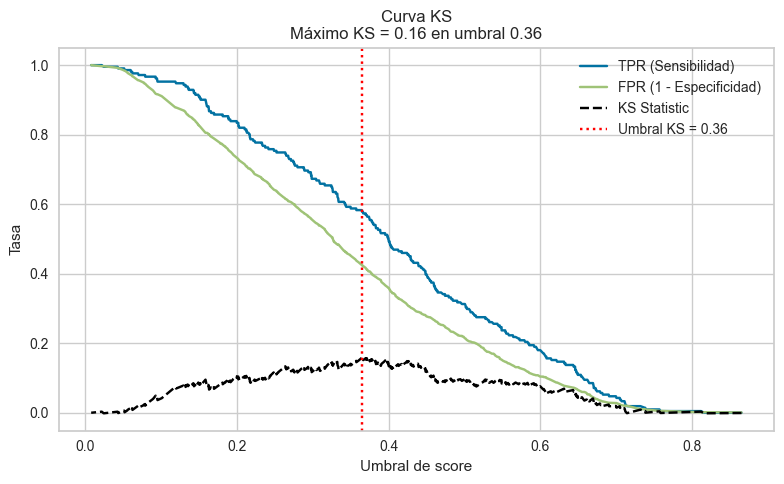

✅ Máximo KS: 0.158
📍 Umbral óptimo (KS): 0.36


In [ ]:
# Generación de curva KS y umbral

# Variables reales y score de probabilidad
y_true = predicciones['cerrara_cuenta']
y_proba = predicciones['prediction_score_1']

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_true, y_proba)

# Calcular estadístico KS
ks_statistic = tpr - fpr
ks_max = np.max(ks_statistic)
ks_threshold = thresholds[np.argmax(ks_statistic)]

# 📈 Graficar curva KS
plt.figure(figsize=(8, 5))
plt.plot(thresholds, tpr, label='TPR (Sensibilidad)')
plt.plot(thresholds, fpr, label='FPR (1 - Especificidad)')
plt.plot(thresholds, ks_statistic, label='KS Statistic', linestyle='--', color='black')
plt.axvline(x=ks_threshold, color='red', linestyle=':', label=f'Umbral KS = {ks_threshold:.2f}')
plt.title(f'Curva KS\nMáximo KS = {ks_max:.2f} en umbral {ks_threshold:.2f}')
plt.xlabel('Umbral de score')
plt.ylabel('Tasa')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Resultado textual
print(f"✅ Máximo KS: {ks_max:.3f}")
print(f"📍 Umbral óptimo (KS): {ks_threshold:.2f}")

In [ ]:
# Predicciones aplicando mejor umbral

predicciones['prediccion_ks'] = (predicciones['prediction_score_1'] >= 0.36).astype(int)

In [ ]:
# Genera matriz de confusión y reporte de clasificación con umbral KS

print("Matriz de confusión con umbral KS:")
print(confusion_matrix(predicciones['cerrara_cuenta'], predicciones['prediccion_ks']))

print("\nReporte de clasificación con umbral KS:")
print(classification_report(predicciones['cerrara_cuenta'], predicciones['prediccion_ks']))

Matriz de confusión con umbral KS:
[[731 558]
 [ 88 123]]

Reporte de clasificación con umbral KS:
              precision    recall  f1-score   support

           0       0.89      0.57      0.69      1289
           1       0.18      0.58      0.28       211

    accuracy                           0.57      1500
   macro avg       0.54      0.58      0.48      1500
weighted avg       0.79      0.57      0.63      1500



In [ ]:
###### PREGUNTAS:


# El mejor modelo que resulta de la comparativa es SVM pero con ese modelo no se pueden responder varias preguntas
# Consideramos que la intención de ejercicio es practicar con todas las planteamientos que se tocan en las preguntas
# por este motivo seleccionamos el siguiente mejor modelo que soporta las característocas para realizar el ejercicio
# y el el lr (regresión logística)

# NOTA: Se realizaron adecuaciones para que el modelo coorriera la tecnica SHAP pero los resultados mostraron errores, mismos 
# que se quedaron en el código, investigando llegamos a la conclusión de que el modelo no soporta esta tecnica

In [ ]:
# 1.- ¿Cuál es el porcentaje de clientes que cerraron su cuenta? ¿Está balanceado el 
# dataset?

# El dataset está desbalanceado con un porcentaje de 14.04 para la clase 1(fuga) y 85.96 para la 
# clase 0(no fuga) 
#

In [ ]:
# 2.- ¿Qué variables tienen mayor correlación con cerrara_cuenta?

# Conforme a la gráfica Mapa de calor que muestra la correlación entre las variables se tiene que 
# las variables que tienen mayor correlación son: satisfaccion_encuesta con -0.14, 
# numero_productos con -0.04 y saldo_total con -0.03
# conforme a el análisis de comportamiento de uso_web, segmento, satisfaccion_encuesta, visitas_app_mes se puede 
# indentificar que la variable que influye más en la predicción de la fuga

In [ ]:
# 3.-  ¿Cuál es el mejor modelo en AUC? ¿Y en Recall?

# svm	SVM - Linear Kernel: es modelo tiene el Recall más alto con  0.4896
# lda	Linear Discriminant Analysis: es modelo que tiene el AUC más alto con 0.6473

In [ ]:
# 4.-  ¿Qué combinación de variables permite identificar clientes silenciosos que se van 
# (sin reclamos)?

# Para la definición del problema en donde se nos dice que se requiere indentificar a los 
# clientes valiosos se considera que el saldo_total es una varible que se debe tomar en cuenta, en este caso
# los que tengan saldo mayor y tengan fuga.
# También, la variable visitas_app_mes ya que si se tiene menor interacción es síntoma de desinteres
# Igualmente, la variable satisfaccion_encuesta, para este caso los que tengan los menores valores.

In [ ]:
# 5.-  ¿Qué pasa si el modelo predice mal un cliente que no se iba (falso positivo)? ¿Y 
# uno que sí se iba (falso negativo)?

# Falso positivo: Si el modelo predice erróneamente que un cliente se va, la empresa 
# podría destinar recursos de retención (bonos, descuentos, llamadas) de forma 
# innecesaria. Esto representa una pérdida operativa, ya que se invierte en 
# clientes equivocados, afectando la eficiencia de las campañas.

# Falso negativo: Si el modelo no detecta que un cliente realmente se va, no se aplican 
# acciones preventivas a tiempo. Aunque no se incurre en gastos inmediatos, sí se pierde 
# capital futuro, oportunidades de venta y el valor total del cliente, lo que 
# puede tener un costo estratégico.
#

In [ ]:
# 6.-  ¿Qué umbral de score (default 0.5 vs optimizado por KS) deberías usar para 
# reducir la pérdida financiera?

# Esta respuesta se realizó utilizando el modelo lr

# Conforme a la gráfica del  modelo de lr el umbral es de 0.36
# Se realizó los cálculos para la matriz de confusión y el reporte de clasificación con el umbral KS

In [ ]:
# 7.-  ¿Cómo explicarías con SHAP que un cliente Premium con buen saldo igual fue 
# predicho como fuga?

# El modelo seleccionado como el mejor nos soporta el uso de SHAP por lo que no podemos 
# responder esta pregunta.

In [ ]:
# 8.- ¿Debería el modelo incluir la tasa de interés ofrecida como predictor, si luego esta 
# puede cambiar según la política de retención?

# Conforma a las gráficas y el análisis se puede ver claramente que la variable de 
# la tasa_credito_personal no descrimina por lo que se puede omitir y en caso de que se
# apliquen políticas de retención la tasa de interés se podría modificar en estas.

In [ ]:
# 9.- ¿Cómo usarías este modelo en un sistema de reglas mixtas (modelo + regla de 
# negocio) para que los gestores humanos no pierdan confianza?

# Al tener un conocimiento del perfil de los clientes que están en fuga 
# se pueden crear campañas de retención enfocadas a sus características. Por ejemplo:
# Si los clientes están en fuga y usan la tecnología se puede utilizar ese canal para 
# manejar productos, promociones o bonos que sean atractivos para esos perfiles.
# O si no usa la tecnología propiciar canales de comunicación face to face.